# Generating Delta File for Fraud Detection
This file will focus on flagging potentially fraudulent transactions based on feature distributions.

In [2]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lower, col
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("Fraud Detection")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

24/10/14 13:34:51 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# Load Aggregated Data
transactions = spark.read.parquet('../data/curated/aggregated_data')

In [3]:
transactions.count()

16115994

## Defining Conditions for Fraudulent Transactions
* High fraud probability, either merchant or consumer is above a threshold value
* Unusually high dollar value in comparison to the user's typical order
* Frequent purchases within a short period

## Data Visualization
To determine threshold values for dollar value and purchase frequency, it can be helpful to visualize the distribution of the targeted variables.

### Dollar Value Distribution

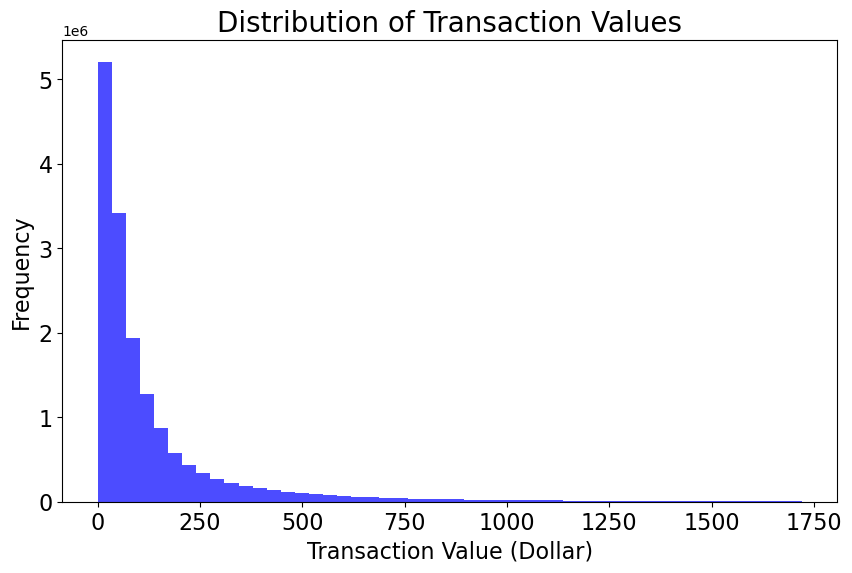

In [7]:
# Visualize the distribution of transaction values

# Convert to Pandas for visualization
df_pandas = transactions.select("dollar_value").toPandas()

# Plot the distribution of dollar_value
plt.figure(figsize=(10,6))
plt.hist(df_pandas['dollar_value'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Transaction Value (Dollar)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Transaction Values', fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

plt.show()

### Fraud Probability Distribution

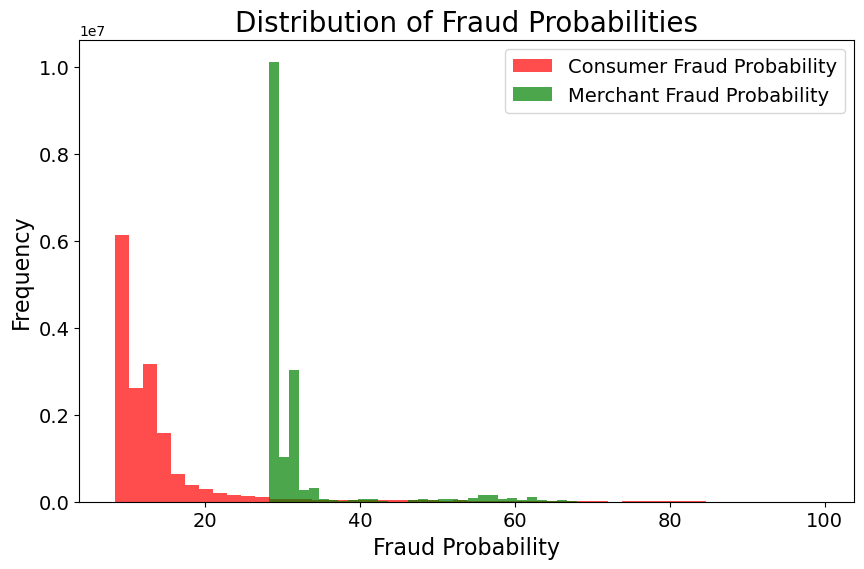

In [9]:
df_pandas_fraud_prob = transactions.select("fraud_probability_consumer", "fraud_probability_merchant").toPandas()

plt.figure(figsize=(10,6))
plt.hist(df_pandas_fraud_prob['fraud_probability_consumer'], bins=50, color='red', alpha=0.7, label="Consumer Fraud Probability")
plt.hist(df_pandas_fraud_prob['fraud_probability_merchant'], bins=50, color='green', alpha=0.7, label="Merchant Fraud Probability")
plt.xlabel('Fraud Probability', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Fraud Probabilities', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.show()


### Purchase Frequency (per Week)

In [4]:
# Extract the week and year
transactions = transactions.withColumn("week_of_year", F.weekofyear("order_datetime"))
transactions = transactions.withColumn("year", F.year("order_datetime"))

# Combine year and and week
transactions = transactions.withColumn("year_week", F.concat_ws("-", F.col("year"), F.col("week_of_year")))

transactions = transactions.drop("week_of_year", "year")
transactions.select("order_datetime", "year_week").show(10)

+--------------+---------+
|order_datetime|year_week|
+--------------+---------+
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
|    2021-11-20|  2021-46|
+--------------+---------+
only showing top 10 rows



#### Consumer Purchase Frequency

In [5]:
# Count the number of transactions per consumer (user_id) per year_week
consumer_weekly_transactions = transactions.groupBy("user_id", "year_week").count()
consumer_weekly_transactions = consumer_weekly_transactions.withColumnRenamed("count", "consumer_weekly_transaction")

consumer_weekly_transactions.show(10)


+-------+---------+---------------------------+
|user_id|year_week|consumer_weekly_transaction|
+-------+---------+---------------------------+
|   1994|  2021-37|                        569|
|   3929|  2021-46|                        581|
|  14014|  2021-52|                       1158|
|  20580|  2021-50|                        585|
|  12401|  2021-46|                        588|
|  13977|  2021-51|                        580|
|  18450|  2021-34|                        594|
|  19913|  2021-46|                       1160|
|  21258|  2021-48|                        573|
|  22422|  2021-46|                        576|
+-------+---------+---------------------------+
only showing top 10 rows



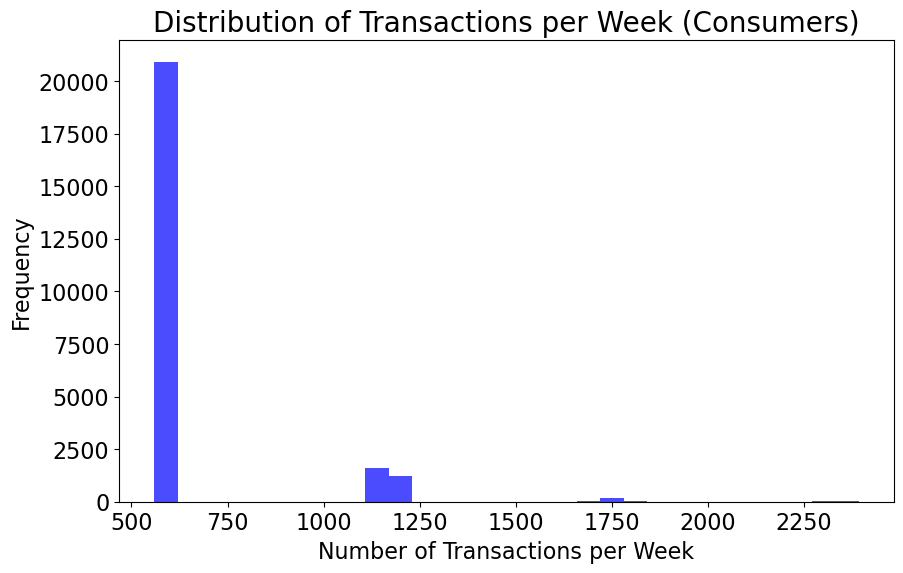

In [14]:
# Convert to Pandas DataFrame for plotting
consumer_weekly_transactions_pandas = consumer_weekly_transactions.select("consumer_weekly_transaction").toPandas()

# Plot the distribution of transactions per week

plt.figure(figsize=(10, 6))
plt.hist(consumer_weekly_transactions_pandas["consumer_weekly_transaction"], bins=30, color="blue", alpha=0.7)
plt.xlabel("Number of Transactions per Week", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Transactions per Week (Consumers)", fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

plt.show()

#### Merchant Purchase Frequency

In [6]:
merchant_weekly_transactions = transactions.groupBy("merchant_abn", "year_week").count()

merchant_weekly_transactions = merchant_weekly_transactions.withColumnRenamed("count", "merchant_weekly_transaction")

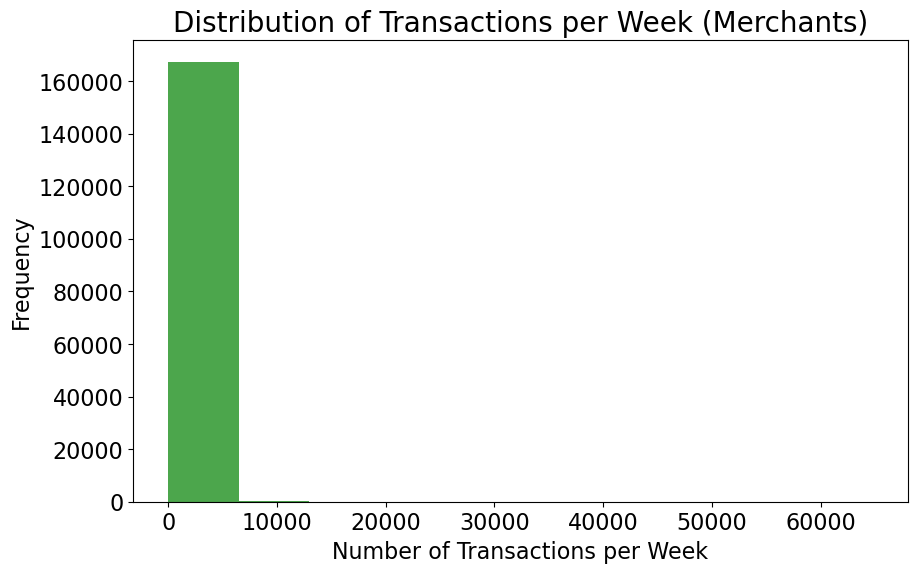

24/09/28 20:56:20 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 618911 ms exceeds timeout 120000 ms
24/09/28 20:56:20 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/28 20:59:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [22]:
merchant_weekly_transactions_pandas = merchant_weekly_transactions.select("merchant_weekly_transaction").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(merchant_weekly_transactions_pandas["merchant_weekly_transaction"], bins=10, color="green", alpha=0.7)

plt.xlabel("Number of Transactions per Week", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Transactions per Week (Merchants)", fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

plt.show()


### Combining Plots into Grid for Presentation Aid

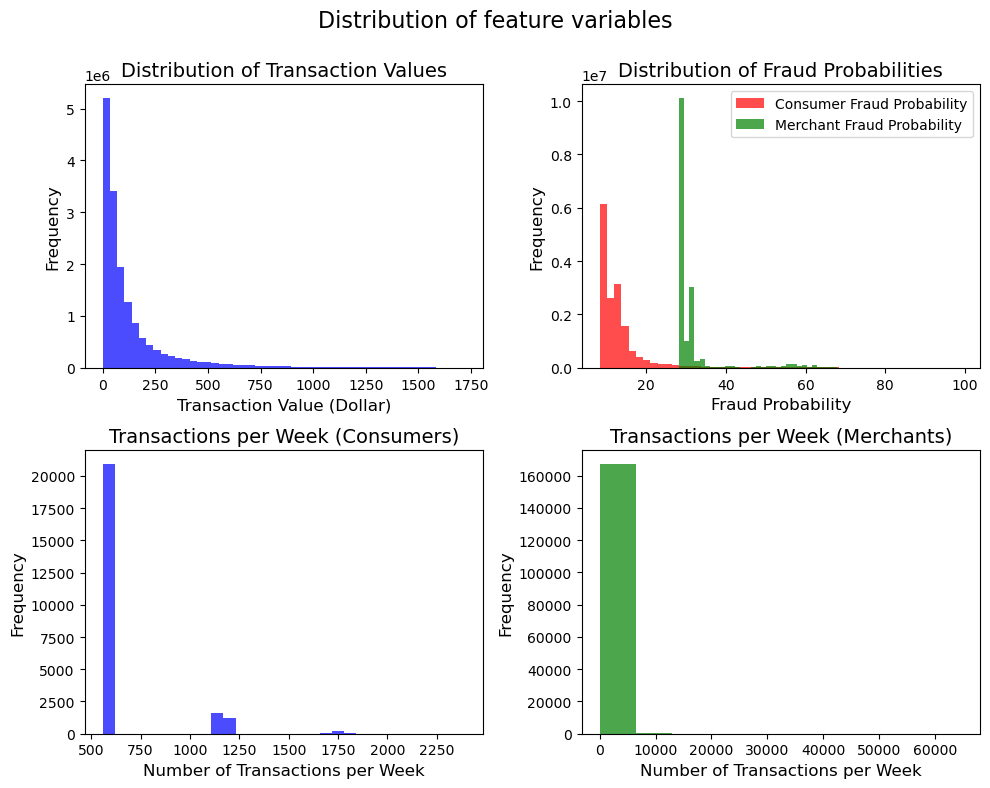

24/10/14 15:01:10 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 328190 ms exceeds timeout 120000 ms
24/10/14 15:01:10 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/14 15:01:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [9]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Distribution of feature variables', fontsize=16)

# Plot 1: Distribution of Transaction Values
df_pandas = transactions.select("dollar_value").toPandas()
axs[0, 0].hist(df_pandas['dollar_value'], bins=50, color='blue', alpha=0.7)
axs[0, 0].set_xlabel('Transaction Value (Dollar)', fontsize=12)
axs[0, 0].set_ylabel('Frequency', fontsize=12)
axs[0, 0].set_title('Distribution of Transaction Values', fontsize=14)

# Plot 2: Distribution of Fraud Probabilities
df_pandas_fraud_prob = transactions.select("fraud_probability_consumer", "fraud_probability_merchant").toPandas()
axs[0, 1].hist(df_pandas_fraud_prob['fraud_probability_consumer'], bins=50, color='red', alpha=0.7, label="Consumer Fraud Probability")
axs[0, 1].hist(df_pandas_fraud_prob['fraud_probability_merchant'], bins=50, color='green', alpha=0.7, label="Merchant Fraud Probability")
axs[0, 1].set_xlabel('Fraud Probability', fontsize=12)
axs[0, 1].set_ylabel('Frequency', fontsize=12)
axs[0, 1].set_title('Distribution of Fraud Probabilities', fontsize=14)
axs[0, 1].legend(fontsize=10)

# Plot 3: Distribution of Transactions per Week (Consumers)
consumer_weekly_transactions_pandas = consumer_weekly_transactions.select("consumer_weekly_transaction").toPandas()
axs[1, 0].hist(consumer_weekly_transactions_pandas["consumer_weekly_transaction"], bins=30, color="blue", alpha=0.7)
axs[1, 0].set_xlabel("Number of Transactions per Week", fontsize=12)
axs[1, 0].set_ylabel("Frequency", fontsize=12)
axs[1, 0].set_title("Transactions per Week (Consumers)", fontsize=14)

# Plot 4: Distribution of Transactions per Week (Merchants)
merchant_weekly_transactions_pandas = merchant_weekly_transactions.select("merchant_weekly_transaction").toPandas()
axs[1, 1].hist(merchant_weekly_transactions_pandas["merchant_weekly_transaction"], bins=10, color="green", alpha=0.7)
axs[1, 1].set_xlabel("Number of Transactions per Week", fontsize=12)
axs[1, 1].set_ylabel("Frequency", fontsize=12)
axs[1, 1].set_title("Transactions per Week (Merchants)", fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('../plots/combined_plots.png', dpi=300)

# Show the plots
plt.show()

### Determining Threhold Values by Percentile
* For fraud probability, the threshold will be determined by visualization.
* Percentile values are used as guidance.

In [11]:
# Calculate the 90th percentile of weekly transactions for consumers
transaction_count_90th = consumer_weekly_transactions.approxQuantile("consumer_weekly_transaction", [0.90], 0.01)[0]
print(f"90th Percentile for Transaction Count per Week (Consumers): {transaction_count_90th}")

# Calculate the 90th percentile for merchants
merchant_transaction_count_90th = merchant_weekly_transactions.approxQuantile("merchant_weekly_transaction", [0.90], 0.01)[0]
print(f"90th Percentile for Transaction Count per Week (Merchants): {merchant_transaction_count_90th}")

90th Percentile for Transaction Count per Week (Consumers): 1150.0


90th Percentile for Transaction Count per Week (Merchants): 144.0


In [12]:
# Calculate the 90th percentile of dollar_value for consumers
dollar_value_90th = transactions.approxQuantile("dollar_value", [0.90], 0.01)[0]
print(f"90th Percentile for Dollar Value: {dollar_value_90th}")

# Calculate the 95th percentile of dollar_value for more extreme cases
dollar_value_95th = transactions.approxQuantile("dollar_value", [0.95], 0.01)[0]
print(f"95th Percentile for Dollar Value: {dollar_value_95th}")

90th Percentile for Dollar Value: 325.2262904243459


95th Percentile for Dollar Value: 520.8081232314929


## Flagging Fraud Transactions

In [13]:
consumer_weekly_transactions.printSchema()
merchant_weekly_transactions.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- year_week: string (nullable = false)
 |-- consumer_weekly_transaction: long (nullable = false)

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = false)
 |-- merchant_weekly_transaction: long (nullable = false)



In [14]:
transactions = transactions.join(consumer_weekly_transactions, on=["user_id","year_week"], how="left")
transactions = transactions.join(merchant_weekly_transactions, on=["merchant_abn", "year_week"], how="left")

transactions.show(5)

+------------+---------+-------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+-----------------+--------------------+---------------------------+---------------------------+
|merchant_abn|year_week|user_id|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|name_consumer| address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|             z_score|consumer_weekly_transaction|merchant_weekly_transaction|
+------------+---------+-------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+--------

### Feature Engineering
Add 'is_fraud' column to flag fraud transactions based on:
* If a transaction dollar_value is above the threshold of 520
* If the frequency of weekly transaction is above the threshold of 1150 (for consumer) or 140 (for merchant)
* If the fraud probability is above the threshold of 50 (for consumer) or 55 (for merchant)

If 2 or more of the criteria is met, a transaction would be flagged as fraudulent.

In [15]:
# Set Threshold Values

cons_freq_threhold = 1000
merch_freq_threhold = 140
dollar_threshold = 500
cons_fraud_threshold = 50
merch_fraud_threshold = 55

In [16]:
# Create columns to represent if each condition is met
transactions = transactions.withColumn(
    "condition1", F.when(F.col("fraud_probability_consumer") >= cons_fraud_threshold, 1).otherwise(0)
).withColumn(
    "condition2", F.when(F.col("fraud_probability_merchant") >= merch_fraud_threshold, 1).otherwise(0)
).withColumn(
    "condition3", F.when(F.col("dollar_value") >= dollar_threshold, 1).otherwise(0)
).withColumn(
    "condition4", F.when(F.col("consumer_weekly_transaction") > cons_freq_threhold, 1).otherwise(0)
).withColumn(
    "condition5", F.when(F.col("merchant_weekly_transaction") > merch_freq_threhold, 1).otherwise(0)
)

# Sum the conditions to determine how many criteria are met
transactions = transactions.withColumn(
    "criteria_met", F.col("condition1") + F.col("condition2") + F.col("condition3") + F.col("condition4") + F.col("condition5")
)

# Flag as fraud if at least 2 out of 5 criteria are met
transactions = transactions.withColumn(
    "is_fraud", F.when(F.col("criteria_met") >= 2, F.lit(True)).otherwise(F.lit(False))
)

transactions = transactions.drop("condition1", "condition2", "condition3", "condition4", "condition5", "criteria_met")

transactions.select("order_id", "is_fraud").show(10)

+--------------------+--------+
|            order_id|is_fraud|
+--------------------+--------+
|00a486bb-258e-476...|   false|
|0003becc-28c1-44f...|   false|
|0029028b-65b3-449...|   false|
|01ace3b8-f331-4c6...|   false|
|011815db-1418-405...|   false|
|02f50243-07df-419...|   false|
|02763734-a451-4c1...|   false|
|00f75c23-77c1-4a1...|   false|
|00c09e20-086a-489...|   false|
|014a1f62-8f5d-446...|   false|
+--------------------+--------+
only showing top 10 rows



In [17]:
#print(transactions.filter(F.col("is_fraud") == True).count())
#print(transactions.filter(F.col("is_fraud") == False).count())

## Extracting Information from Tags

In [18]:
from pyspark.sql.functions import regexp_extract, col, when

# Define regular expressions to extract each part from the tags
# Allowing either parentheses () or square brackets []
category_regex = r'[\(\[][\(\[](.*?)[\)\]],'  # Matches everything between '((' or '[[' and ','
revenue_band_regex = r', [\(\[](.+?)[\)\]],'  # Matches a single letter or word between ', (' or ', [' and ','
take_rate_regex = r'take rate: ([0-9]*\.[0-9]+)[\)\]]'  # Matches the 'take rate' value
unknown_tag_regex = r'Unknown Tag \d+'  # Matches "Unknown Tag ####" pattern

# Apply the regular expressions to extract the parts, and handle "Unknown Tag ####" rows
transactions = transactions.withColumn(
    "merchant_category",
    when(col("tags").rlike(unknown_tag_regex), None)
    .otherwise(regexp_extract(col("tags"), category_regex, 1))
).withColumn(
    "revenue_band",
    when(col("tags").rlike(unknown_tag_regex), None)
    .otherwise(regexp_extract(col("tags"), revenue_band_regex, 1))
).withColumn(
    "take_rate",
    when(col("tags").rlike(unknown_tag_regex), None)
    .otherwise(regexp_extract(col("tags"), take_rate_regex, 1).cast("float"))
)

# Show the resulting DataFrame with new columns
transactions.select("merchant_category", "revenue_band", "take_rate").show(truncate=False, n=10)


+------------------------------------------------------+------------+---------+
|merchant_category                                     |revenue_band|take_rate|
+------------------------------------------------------+------------+---------+
|digital goods: books, movies, music                   |b           |4.7      |
|gift, card, novelty, and souvenIr shops               |b           |4.95     |
|opticians, oPtical goods, and eyeglasses              |a           |6.64     |
|gift, card, novelty, and souvenir shops               |c           |1.47     |
|shoe shops                                            |a           |6.11     |
|opticians, optical goods, and eyeglasses              |c           |2.62     |
|computers, compUter peripheral equipment, and software|b           |3.49     |
|computers, computer peripheral equipment, and software|c           |3.05     |
|digital goods: books, movies, music                   |a           |7.0      |
|artist supply aNd cRaft shops          

### Imputing Unknown Tags

In [19]:
# Impute unknown take rate with median
median_value = transactions.approxQuantile("take_rate", [0.5], 0.01)[0] 
transactions = transactions.withColumn(
    "take_rate",
    when(col("take_rate").isNull(), median_value).otherwise(col("take_rate"))
)

# Impute unknown category and revenue band by mode

mode_revenue_band = transactions.groupBy("revenue_band").count().orderBy(F.desc("count")).first()[0]

mode_merchant_category = transactions.groupBy("merchant_category").count().orderBy(F.desc("count")).first()[0]

transactions = transactions.withColumn("revenue_band", 
                                       F.when(F.col("revenue_band").isNull(), mode_revenue_band).otherwise(F.col("revenue_band")))

transactions = transactions.withColumn("merchant_category", 
                                       F.when(F.col("merchant_category").isNull(), mode_merchant_category).otherwise(F.col("merchant_category")))


In [20]:
# Define a function to clean up the text (convert to lowercase and remove extra spaces)
clean_text_udf = F.udf(lambda x: " ".join(x.lower().split()) if x else None)

# Apply the function to the merchant_category column
transactions = transactions.withColumn(
    'merchant_category_cleaned', clean_text_udf(F.col('merchant_category'))
)

# Show the cleaned categories
transactions.select('merchant_category', 'merchant_category_cleaned').show(10, truncate=False)


+------------------------------------------------------+------------------------------------------------------+
|merchant_category                                     |merchant_category_cleaned                             |
+------------------------------------------------------+------------------------------------------------------+
|digital goods: books, movies, music                   |digital goods: books, movies, music                   |
|gift, card, novelty, and souvenIr shops               |gift, card, novelty, and souvenir shops               |
|opticians, oPtical goods, and eyeglasses              |opticians, optical goods, and eyeglasses              |
|gift, card, novelty, and souvenir shops               |gift, card, novelty, and souvenir shops               |
|shoe shops                                            |shoe shops                                            |
|opticians, optical goods, and eyeglasses              |opticians, optical goods, and eyeglasses        

In [23]:
transactions = transactions.drop('merchant_category') \
                           .withColumnRenamed('merchant_category_cleaned', 'merchant_category')

In [24]:
# Check for Null Values
transactions_null = transactions.agg(
    *(F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in transactions.columns)
)
transactions_null.show()

+------------+---------+-------+------------+--------+-----------+--------------------------+-------------+----------------+--------------+-----------------+---------------+-------------+----+--------------------------+--------------+----------------+-------------+-------------+-----------------+-------+---------------------------+---------------------------+--------+------------+---------+-----------------+
|merchant_abn|year_week|user_id|dollar_value|order_id|consumer_id|fraud_probability_consumer|name_consumer|address_consumer|state_consumer|postcode_consumer|gender_consumer|name_merchant|tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|z_score|consumer_weekly_transaction|merchant_weekly_transaction|is_fraud|revenue_band|take_rate|merchant_category|
+------------+---------+-------+------------+--------+-----------+--------------------------+-------------+----------------+--------------+-----------------+---------------+---

In [27]:
# Drop columns that are not needed
transactions = transactions.drop("tags", "z_score")
transactions.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = false)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- consumer_weekly_transaction: long (nullable = true)
 |-- merchant_weekly_transaction: long (nullable = true)
 |-- is

## Export Final Complete Data

In [28]:
transactions.write.parquet('../data/curated/flagged_fraud')